In [1]:
%matplotlib widget
from typing import Tuple, List, Optional
from dataclasses import dataclass
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact_manual


# import matplotlib
# LW=5 # linewidth
# MS=10 # markersize

# Kalman Filtering
Alex Gorodetsky, November 2020, March 2024

The Kalman filter refers to the solution of the filtering equations for linear-Gaussian systems. Recall the filtering equations

1. Predict: $P(X_{k} \mid y_1,\ldots,y_{k-1}) = \int P( X_k \mid X_{k-1}) P (X_{k-1} \mid y_1,\ldots,y_{k-1} )dX_{k-1}$
2. Update: $P(X_{k} \mid y_1,\ldots, y_{k}) = \frac{P(Y_k = y_k\mid X_{k}) P(X_{k} \mid y_1,\ldots,y_{k-1})}{P(Y_1 \mid y_1,\ldots,y_{k-1})}$

The linear system we are considering consists of dynamics
\begin{equation}
X_{k+1} = A X_{k} + \xi, \quad \xi \sim \mathcal{N}(m_{\xi}, \Sigma)
\end{equation}
and measurements
\begin{equation}
Y_{k} = H X_{k} + \eta, \quad \eta \sim \mathcal{N}(m_{\eta}, \Gamma)
\end{equation}

Note that we allow the noise to have bias to generalize a little bit. In the examples we will assume zero bias but the code is general. We also start with a prior $X_0 \sim \mathcal{N}(m_0, C_0).$

Before we begin to code these things, lets create some utility data structures to help organize the information

In [2]:
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

### Prediction equations

If we have that $X_{k-1} \mid \mathcal{Y}_{k-1} \sim \mathcal{N}(m_{k-1}, C_{k-1}).$ Then we have 
\begin{equation}
X_{k} \mid \mathcal{Y}_{k-1} \sim \mathcal{N}(A m_{k-1}, A C_{k-1} A^T + \Sigma)
\end{equation}

In [3]:
def linear_prediction_step(A: np.ndarray, X: Gaussian, xi: Gaussian) -> Gaussian:
    """Linear Prediction Step: Propagate uncertainty for one time step.

    X_{k+1} = A X_{k} + xi, xi sim mathcal{N}{noise_mean, noise_cov}
    X_{k} sim mathcal{N}(mean, cov)

    Inputs
    ------
    A: (d, d) linear matrix
    X: Gaussian
    xi: Gaussian

    Returns
    -------
    A Gaussian random variable for the next time step
    """

    pred_mean = np.dot(A, X.mean) + xi.mean
    pred_cov = np.dot(A, np.dot(X.cov, A.T)) + xi.cov
    return Gaussian(pred_mean, pred_cov)

### Update equations

If we have that $X_{k} \mid \mathcal{Y}_{k-1} \sim \mathcal{N}(m_{k}^-, C_{k}^-).$ Then we have 

$$
X_{k} \mid \mathcal{Y}_{k} \sim \mathcal{N}(m_{k}^- + US^{-1}(y_k - \mu), C^-_{k} - US^{-1}U^T)
$$

where 

$$
U \equiv \textrm{Cov}[X_{k}, Y_{k}] = C_{k}^- H^T
$$

$$
S \equiv \textrm{Var}[Y_{k}] = HC_{k}^-H^T + \Gamma
$$

$$
\mu \equiv \mathbb{E}[Y_{k}] = Hm_{k}^- + m_{\eta}
$$


In [4]:
def linear_update_step(data: np.ndarray, H: np.ndarray, X: Gaussian, eta: Gaussian):
    """Linear Gaussian Inverse Problem.

    Inputs
    ------
    data: (N) array of data
    H: (N, d) linear model
    X: Gaussian
    eta: Gaussian

    Returns
    -------
    Gaussian Posterior
    """
    U = np.dot(X.cov, H.T)
    S = np.dot(H, U) + eta.cov
    mu = np.dot(H, X.mean) + eta.mean

    update_mean = X.mean + np.dot(U, np.linalg.solve(S, data - mu))
    update_cov = X.cov - np.dot(U, np.linalg.solve(S, U.T))
    return Gaussian(update_mean, update_cov)

## The Kalman filter

The Kalman filter now simply propagates between data, and then updates with data.

In [5]:
@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray  # index of times that are observed
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [6]:
def kalman_filter(data: Observations,
                  A: np.ndarray,
                  H: np.ndarray,
                  X: Gaussian,
                  xi: Gaussian, eta: Gaussian) -> Tuple[np.ndarray, np.ndarray]:
    """The Kalman filter.

    Inputs
    ------
    data: (N, m), N is the number of time steps, m is the size of the observations
    A: (d, d), dynamics
    H: (m, d), observation operator
    X: prior Gaussian
    xi: process noise
    eta: measurement noise

    Return
    ------
    KFTracker

    Note
    ----
    Assumes timestep of dynamics is the same as data! Will have to update for projects
    """

    num_steps = data.times.shape[0]

    d = X.mean.shape[0]
    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(X.mean)
    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(X.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    #Loop over all time steps
    Xnext = X
    on_obs = 0
    for ii in range(1, num_steps):
        # Prediction
        Xpred = linear_prediction_step(A, Xnext, xi)

        # We have an observation so an update must occur
        if on_obs < data.obs_ind.shape[0] and ii == data.obs_ind[on_obs]:
            y = data.obs[on_obs]
            on_obs += 1

            # Update
            Xup = linear_update_step(y, H, Xpred, eta)
            Xnext = Xup

        else:
            Xnext = Xpred

        mean_store[ii, :] = np.copy(Xnext.mean)
        cov_store[ii, : ,:] = np.copy(Xnext.cov)
        std_store[ii, :] = np.sqrt(np.diag(cov_store[ii, :, :]))

    return KFTracker(mean_store, cov_store, std_store)

## Set up a problem

Two dimensional system
\begin{equation}
\begin{bmatrix}
\dot{x}_1 \\
\dot{x}_2
\end{bmatrix} 
= 
\begin{bmatrix}
0 & 1 \\
a & b 
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
\end{equation}
where $a$ and $b$ are negative. This is a second order system, think of a mass-spring-damper where the $a$ and $b$ are functions of the spring and damping coefficients

In [7]:
def generate_data(times: np.ndarray,
                  obs_freq: int,
                  x0: np.ndarray,
                  A: np.ndarray,
                  H: np.ndarray,
                  obs_names: List[str],
                  noise_std: float=1e-2) -> Tuple[Observations, Observations]:
    """Generate the truth and data for the second-order system"""
    N = times.shape[0]
    xout = np.zeros((N, 2))
    obs_ind = np.arange(obs_freq, N, obs_freq)
    num_obs =  obs_ind.shape[0]

    m = H.shape[0]
    yout = np.zeros((num_obs, m))

    xout[0, :] = x0
    on_obs = 0
    for ii in range(1, N):
        xout[ii, :] = np.dot(A,  xout[ii-1, :])
        if on_obs < obs_ind.shape[0] and ii == obs_ind[on_obs]:
            yout[on_obs, :] = np.dot(H, xout[ii, :]) + noise_std * np.random.randn(m)
            on_obs += 1

    trueData = Observations(times, np.arange(N), xout, ['state0', 'state1'])
    obsData = Observations(times, obs_ind, yout, obs_names)
    return trueData, obsData

We use a forward euler to approximate a continuous time system $\dot{x} = Ax$
\begin{equation}
x_{k+1} = x_{k} + \Delta t A x_k = (I + \Delta t A) x_k
\end{equation}

In [8]:
Atruth = np.array([[0, 1.0], [-0.5, -0.5]])
dt = 1e-1
Atruth = dt * Atruth + np.eye(2)
T = 10
Nsims = int(T / dt)
t = np.linspace(0, T, Nsims + 1)
x0 = np.array([1.0, 2.0])

Next we create a utility that helps with plotting

In [9]:
def plot_data_and_truth(fignum, true_obs: Observations, data_obs: Observations,
                        kft: Optional[KFTracker] = None) -> plt.figure:

    colors = ['red', 'blue', 'green']
    plt.close(fignum)
    fig = plt.figure(fignum)
    plt.plot(true_obs.times, true_obs.obs[:, 0], color=colors[0], label='state0')
    plt.plot(true_obs.times, true_obs.obs[:, 1], color=colors[1], label='state1')

    for ii in range(data_obs.obs.shape[1]):
        plt.plot(data_obs.times[data_obs.obs_ind], data_obs.obs[:, ii],
                 'o', color=colors[ii], alpha=0.4, label=data_obs.names[ii])

    if kft is not None:
        plt.plot(data_obs.times, kft.means[:, 0], '--', color=colors[0], label='est-state0')
        plt.plot(data_obs.times, kft.means[:, 1], '--', color=colors[1], label='est-state1')
        plt.fill_between(data_obs.times,
                         kft.means[:, 0] - 2 * kft.stds[:, 0],
                         kft.means[:, 0] + 2 * kft.stds[:, 0],
                         color=colors[0], alpha=0.3)
        plt.fill_between(data_obs.times,
                         kft.means[:, 1] - 2 * kft.stds[:, 1],
                         kft.means[:, 1] + 2 * kft.stds[:, 1],
                         color=colors[1], alpha=0.3)

    plt.legend()
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('State Estimate',fontsize=14)
    return fig

Next we create a prior that will be used throughout.

In [10]:
X = Gaussian(np.zeros((2)), 5 * np.eye(2))

## Case 1: Full observations

Lets begin by first considering that we can observe every state
\begin{equation}
H = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
\end{equation}

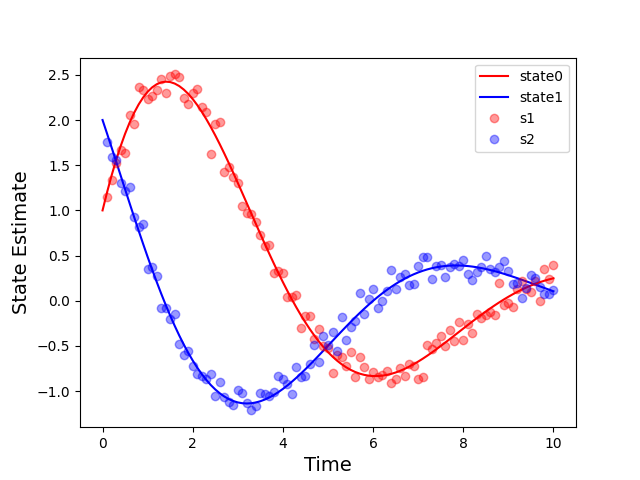

In [11]:
obs_names = ['s1', 's2']
H = np.eye(2)
truth, noisy_obs = generate_data(t, 1, x0, Atruth, H, obs_names, noise_std=1e-1)
plot_data_and_truth(1, truth, noisy_obs)

# Note simulation can use Asim instead of Atruth and meas_cov instead of true noise
Asim = np.array([[0, 1.0], [-0.5, -0.5]]) # no model error
# Asim = np.array([[0, 1.0], [-0.4, -0.7]]) # model error
# Asim = np.array([[0, 1.0], [-0.4, 2.0]])
Asim = dt * Asim + np.eye(2)
process_noise = Gaussian(0, 1e-1 * np.eye(2))
meas_noise = Gaussian(np.zeros((H.shape[0])), 1e0 * np.eye(H.shape[0]))
kf_res = kalman_filter(noisy_obs, Asim, H, X, process_noise, meas_noise)


Now lets take a look at the filtered version.

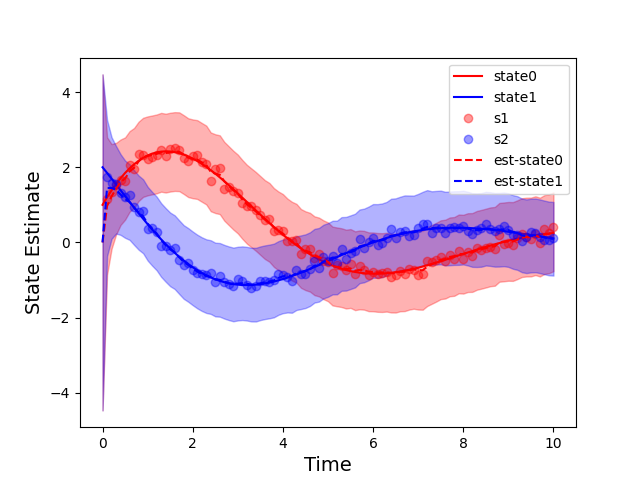

In [12]:
fig2 = plot_data_and_truth(2, truth, noisy_obs, kf_res)

We see that we start with large uncertainty on both states, but the uncertainty quickly converges to a band, and this band seems to be centered on the trut (dotted matches solid). Lets make the parameters of what we have done a bit tunable so we can see the affects of everything. In particular try to look at some cases where measurement noise is higher than process noise and visa versa. Also look at the effect of increasing and decreasing the observation frequency. Also take a look at using slightly wrong models

In [13]:
@interact_manual(obs_freq=(1, 10, 1),
                 log_proc_noise_filter=(-4, 1, 0.1),
                 log_meas_noise_filter=(-4, 1, 0.1),
                 which_model=[('true', 0), ('error1', 1), ('error2', 2)])
def run_fully_obs(obs_freq=1,
                  log_proc_noise_filter=-1,
                  log_meas_noise_filter=0,
                  which_model=0):
    obs_names = ['s1', 's2']
    H = np.eye(2)
    truth, noisy_obs = generate_data(t, obs_freq, x0, Atruth, H,
                                     obs_names, noise_std=1e-1)

    if which_model == 0:
        Asim = np.array([[0, 1.0], [-0.5, -0.5]]) # no model error
    elif which_model == 1:
        Asim = np.array([[0, 1.0], [-0.4, -0.7]]) # model error
    elif which_model == 2:
        Asim = np.array([[0, 1.0], [-0.4, 2.0]])
    Asim = dt * Asim + np.eye(2)

    process_noise = Gaussian(0, 10**(log_proc_noise_filter) * np.eye(2))
    meas_noise = Gaussian(np.zeros((H.shape[0])),
                          10**(log_meas_noise_filter) * np.eye(H.shape[0]))
    kf_res = kalman_filter(noisy_obs, Asim, H, X, process_noise, meas_noise)
    fig3 = plot_data_and_truth(3, truth, noisy_obs, kf_res)
    plt.tight_layout()
    plt.show()
    print("showing")

interactive(children=(IntSlider(value=1, description='obs_freq', max=10, min=1), FloatSlider(value=-1.0, descr…

## Partial observation, only looking at measuring the first state

Lets look at what happens when we only measure 
\begin{equation}
H = \begin{bmatrix} 1 & 0 \end{bmatrix}
\end{equation}

In [14]:
@interact_manual(obs_freq=(1, 10, 1),
                 log_proc_noise_filter=(-4, 1, 0.1),
                 log_meas_noise_filter=(-4, 1, 0.1),
                 which_model=[('true', 0), ('error1', 1), ('error2', 2)])
def run_first_state(obs_freq=1,
                  log_proc_noise_filter=-1,
                  log_meas_noise_filter=0,
                  which_model=0):
    obs_names = ['s1']
    H = np.array([[1, 0]])
    truth, noisy_obs = generate_data(t, obs_freq, x0, Atruth, H,
                                     obs_names, noise_std=1e-1)

    if which_model == 0:
        Asim = np.array([[0, 1.0], [-0.5, -0.5]]) # no model error
    elif which_model == 1:
        Asim = np.array([[0, 1.0], [-0.4, -0.7]]) # model error
    elif which_model == 2:
        Asim = np.array([[0, 1.0], [-0.4, 2.0]])
    Asim = dt * Asim + np.eye(2)

    process_noise = Gaussian(0, 10**(log_proc_noise_filter) * np.eye(2))
    meas_noise = Gaussian(np.zeros((H.shape[0])),
                          10**(log_meas_noise_filter) * np.eye(H.shape[0]))
    kf_res = kalman_filter(noisy_obs, Asim, H, X, process_noise, meas_noise)
    fig4 = plot_data_and_truth(4, truth, noisy_obs, kf_res)
    plt.tight_layout()
    plt.show()
    print("showing")

interactive(children=(IntSlider(value=1, description='obs_freq', max=10, min=1), FloatSlider(value=-1.0, descr…

## Now we just observe just the second state

The observation model becomes
\begin{equation}
H = 
\begin{bmatrix}
0 & 1
\end{bmatrix}
\end{equation}

In [15]:
@interact_manual(obs_freq=(1, 10, 1),
                 log_proc_noise_filter=(-4, 1, 0.1),
                 log_meas_noise_filter=(-4, 1, 0.1),
                 which_model=[('true', 0), ('error1', 1), ('error2', 2)])
def run_second_state(obs_freq=1,
                     log_proc_noise_filter=-1,
                     log_meas_noise_filter=0,
                     which_model=0):
    obs_names = ['s2']
    H = np.array([[0, 1]])
    truth, noisy_obs = generate_data(t, obs_freq, x0, Atruth, H,
                                     obs_names, noise_std=1e-1)

    if which_model == 0:
        Asim = np.array([[0, 1.0], [-0.5, -0.5]]) # no model error
    elif which_model == 1:
        Asim = np.array([[0, 1.0], [-0.4, -0.7]]) # model error
    elif which_model == 2:
        Asim = np.array([[0, 1.0], [-0.4, 2.0]])
    Asim = dt * Asim + np.eye(2)

    process_noise = Gaussian(0, 10**(log_proc_noise_filter) * np.eye(2))
    meas_noise = Gaussian(np.zeros((H.shape[0])),
                          10**(log_meas_noise_filter) * np.eye(H.shape[0]))
    kf_res = kalman_filter(noisy_obs, Asim, H, X, process_noise, meas_noise)
    fig5 = plot_data_and_truth(5, truth, noisy_obs, kf_res)
    plt.tight_layout()
    plt.show()
    print("showing")

interactive(children=(IntSlider(value=1, description='obs_freq', max=10, min=1), FloatSlider(value=-1.0, descr…

## Observability. 

If you have taken linear systems before you may have heard of the term "Observability", which roughly addresses the question of whether you can recover the true (initial) state of the system from observations. Lets take a look at the observability of our system for the different cases.

Lets start with the true systems and the three observation matrices.

In [16]:
def check_obs(A, H):
    b1 = H
    b2 = np.dot(H, A)
    B = np.vstack((b1, b2))
    rank = np.linalg.matrix_rank(B)
    return rank, rank == 2

In [17]:
print(check_obs(Atruth, np.eye(2)))
print(check_obs(Atruth, np.array([[1, 0]])))
print(check_obs(Atruth, np.array([[0, 1]])))

(2, True)
(2, True)
(2, True)


All these systems are observable and so it makes sense we can recover the truth. 

Lets consider an interesting system and see if it is observable

$$
A = \begin{bmatrix} 0 & 1 \\ 1 & 0  \end{bmatrix}
$$
$$
H = [1, 1].
$$
Where we observe the sum of the two states

In [18]:
print(check_obs(np.array([[0, 1],[1, 0]]), np.array([[1, 1]])))

(1, False)


Now lets implement it

In [19]:
@interact_manual(obs_freq=(1, 10, 1),
                 log_proc_noise_filter=(-4, 1, 0.1),
                 log_meas_noise_filter=(-4, 1, 0.1))
def run_unobservable(obs_freq=1,
                     log_proc_noise_filter=-1,
                     log_meas_noise_filter=0):
    obs_names = ['sum']
    H = np.array([[1, 1]])
    A = 1.0 * np.array([[0, 1], [1, 0]])
    truth, noisy_obs = generate_data(t, obs_freq, x0, A, H,
                                     obs_names, noise_std=1e-1)

    Asim = A
    process_noise = Gaussian(0, 10**(log_proc_noise_filter) * np.eye(2))
    meas_noise = Gaussian(np.zeros((H.shape[0])),
                          10**(log_meas_noise_filter) * np.eye(H.shape[0]))
    kf_res = kalman_filter(noisy_obs, Asim, H, X, process_noise, meas_noise)
    fig6 = plot_data_and_truth(6, truth, noisy_obs, kf_res)
    plt.tight_layout()
    plt.show()
    print("showing")

interactive(children=(IntSlider(value=1, description='obs_freq', max=10, min=1), FloatSlider(value=-1.0, descr…

Of course in this case if observe just 1 of the states it becomes observable!

In [20]:
print(check_obs(np.array([[0, 1],[1, 0]]), np.array([[0, 1]])))

(2, True)


So lets run the filter and see what happens

In [21]:
@interact_manual(obs_freq=(1, 10, 1),
                 log_proc_noise_filter=(-10, 1, 0.1),
                 log_meas_noise_filter=(-4, 1, 0.1))
def run_observable(obs_freq=1,
                     log_proc_noise_filter=-1,
                     log_meas_noise_filter=0):
    obs_names = ['s2']
    H = np.array([[0, 1]])
    A = 1.0 * np.array([[0, 1], [1, 0]])
    truth, noisy_obs = generate_data(t, obs_freq, x0, A, H,
                                     obs_names, noise_std=1e-1)

    Asim = A
    process_noise = Gaussian(0, 10**(log_proc_noise_filter) * np.eye(2))
    meas_noise = Gaussian(np.zeros((H.shape[0])),
                          10**(log_meas_noise_filter) * np.eye(H.shape[0]))
    kf_res = kalman_filter(noisy_obs, Asim, H, X, process_noise, meas_noise)
    fig7 = plot_data_and_truth(7, truth, noisy_obs, kf_res)
    plt.tight_layout()
    plt.show()
    print("showing")

interactive(children=(IntSlider(value=1, description='obs_freq', max=10, min=1), FloatSlider(value=-1.0, descr…